

# RNN for Time Series

RNNs are used for sequence modeling. This tutorial will look at a time series data to be modeled and predicted using RNNs. 

In [1]:
#
# Import Libraries
#
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Data

We will use retail data for time-series modeling. 

Link to the dataset:
 https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at:
https://www.census.gov/retail/marts/about_the_surveys.html

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted
Frequency:  Monthly

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

### Read data first -  Use index_col = 'DATE' and 'parse_dates = True' as a parameter.

In [4]:
# Your code to read data
df = pd.read_csv('MRTSSM448USN.csv', index_col='DATE', parse_dates=True)
# Print first few rows of data
df.head()

,MRTSSM448USN
DATE,
1992-01-01,6938.0
1992-02-01,7524.0
1992-03-01,8475.0
1992-04-01,9401.0
1992-05-01,9558.0


Does the sales column has any name?

If no, set the name of the colum as 'Sales'.

In [7]:
# Set name of column as 'Sales'. Use - df.columns 
df.columns

Index(['MRTSSM448USN'], dtype='object')

In [8]:
df.rename(columns = {'MRTSSM448USN':'Sales'}, inplace=True)
df.head()

,Sales
DATE,
1992-01-01,6938.0
1992-02-01,7524.0
1992-03-01,8475.0
1992-04-01,9401.0
1992-05-01,9558.0


Plot your data - Year vs Sales

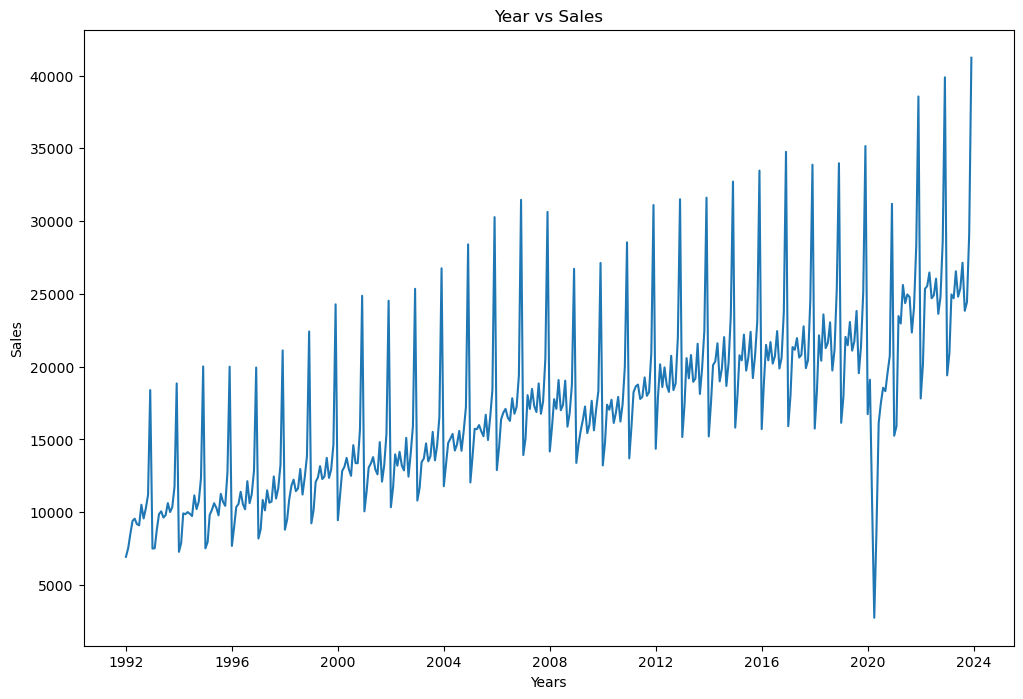

In [10]:
# Your code to plot Year vs Sales. Use either matplot library of pandas dataframe.
plt.figure(figsize = (12, 8))

plt.plot(df)
plt.title('Year vs Sales')
plt.xlabel('Years')
plt.ylabel('Sales')
plt.show()

### Next we will do Train Test Split. 

We will use last 1.5 year (18 month) samples for testing. Rest is for training.

In [ ]:
# Assign variable test size = 18
# Store length of data in variable length.
# store training size in varialable train_size (Remember training size = total size - test_size)
test_size = 18


Now, we will find the indexes of the test data. Remember, these are the last 18 indexes in the pandas dataframe.

In [12]:
#Assign the start of test index in data frame to variable test_index.  
#Remember, it is equal to the length of dataframe - test size
test_index = 18

Next, we will separate train and test datasets.

In [15]:
# Store all data from 0 to test_index in variable train. Hint - Use df.iloc.
# Store everthing from test_index to the last sample in test variable. Hint - Use df.iloc.
test = df.iloc[len(df) - test_index : len(df)]
test.head()

,Sales
DATE,
2022-07-01,24904.0
2022-08-01,26049.0
2022-09-01,23629.0
2022-10-01,24787.0
2022-11-01,28645.0


In [28]:
train = df.iloc[:len(df) - test_index]
train.head()

,Sales
DATE,
1992-01-01,6938.0
1992-02-01,7524.0
1992-03-01,8475.0
1992-04-01,9401.0
1992-05-01,9558.0


In [31]:
# Print the size of the train data
# Print the size of the test data
# Print the train data
# Print the test data
print(len(train))
print(len(test))
print(train)
print(test)

366
18
              Sales
DATE               
1992-01-01   6938.0
1992-02-01   7524.0
1992-03-01   8475.0
1992-04-01   9401.0
1992-05-01   9558.0
...             ...
2022-02-01  20152.0
2022-03-01  25347.0
2022-04-01  25539.0
2022-05-01  26470.0
2022-06-01  24701.0

[366 rows x 1 columns]
              Sales
DATE               
2022-07-01  24904.0
2022-08-01  26049.0
2022-09-01  23629.0
2022-10-01  24787.0
2022-11-01  28645.0
2022-12-01  39883.0
2023-01-01  19405.0
2023-02-01  20937.0
2023-03-01  24963.0
2023-04-01  24700.0
2023-05-01  26557.0
2023-06-01  24809.0
2023-07-01  25364.0
2023-08-01  27143.0
2023-09-01  23840.0
2023-10-01  24438.0
2023-11-01  29150.0
2023-12-01  41228.0


### In Neural Networks, we need to Scale Data between 0-1

In [32]:
from sklearn.preprocessing import MinMaxScaler

In [36]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
#
# Check if the data has been scaled properly
#

In [49]:
#print(scaled_train)
print(scaled_test)

[[0.61856361]
 [0.65053613]
 [0.58296102]
 [0.61529655]
 [0.7230258 ]
 [1.03683123]
 [0.46501173]
 [0.50779068]
 [0.6202111 ]
 [0.6128672 ]
 [0.66472132]
 [0.61591087]
 [0.63140847]
 [0.68108455]
 [0.5888529 ]
 [0.60555121]
 [0.73712722]
 [1.07438847]]


In [51]:
scaled_test.shape

(18, 1)

# Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

# We will use 12 months as input and then predict the next month out


In [39]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [56]:
print(generator[2])

(array([[[0.15980677],
        [0.18566402],
        [0.19004803],
        [0.17954875],
        [0.17734279],
        [0.21671507],
        [0.19046688],
        [0.20948285],
        [0.23553557],
        [0.43680889],
        [0.1326371 ],
        [0.13325142]]]), array([[0.16793254]]))


In [52]:
X, y = generator[0]

print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.11688819 0.13325142 0.15980677 0.18566402 0.19004803 0.17954875
 0.17734279 0.21671507 0.19046688 0.20948285 0.23553557 0.43680889]
Predict this y: 
 [[0.1326371]]


### Create the Model

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import GRU

import tensorflow as tf

In [58]:
# We're only using one feature in our time series
n_features = 1

# Define your own models. 

Use 1. SimpleRNN, LSTM, or GRU neural network.

APIs:
https://keras.io/api/layers/recurrent_layers/

In [59]:
# 
# Your code to create your own model
#
model = Sequential()
#model.add()
model.add(SimpleRNN(100, activation = 'relu', input_shape = (12, n_features)))
model.add(Dense(1))

In [60]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100)               10200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 10301 (40.24 KB)
Trainable params: 10301 (40.24 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [61]:
model.compile(optimizer='adam', loss='mse')

### EarlyStopping and creating a Validation Generator

NOTE: The scaled_test dataset size MUST be greater than your length chosen for your batches. Review video for more info on this.

In [62]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1)

In [66]:
from tensorflow.keras.callbacks import EarlyStopping

# Your code to create an object early-stop.
early_stop = EarlyStopping(monitor='val_loss', patience=5)

Now, fit your model.

In [67]:
# Your code to fit your model.
model.fit(generator, validation_data= validation_generator, callbacks=[early_stop], epochs=30)

Epoch 1/30
354/354 [==============================] - 2s 6ms/step - loss: 0.0029 - val_loss: 7.4139e-04
Epoch 2/30
354/354 [==============================] - 2s 6ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 3/30
354/354 [==============================] - 2s 6ms/step - loss: 0.0041 - val_loss: 0.0032
Epoch 4/30
354/354 [==============================] - 2s 6ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 5/30
354/354 [==============================] - 2s 6ms/step - loss: 0.0029 - val_loss: 0.0067
Epoch 6/30
354/354 [==============================] - 2s 6ms/step - loss: 0.0020 - val_loss: 6.0379e-04
Epoch 7/30
354/354 [==============================] - 2s 6ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 8/30
354/354 [==============================] - 2s 6ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 9/30
354/354 [==============================] - 2s 6ms/step - loss: 0.0023 - val_loss: 3.2878e-04
Epoch 10/30
354/354 [==============================] - 2s 6ms/step - loss: 0.0018 - val_

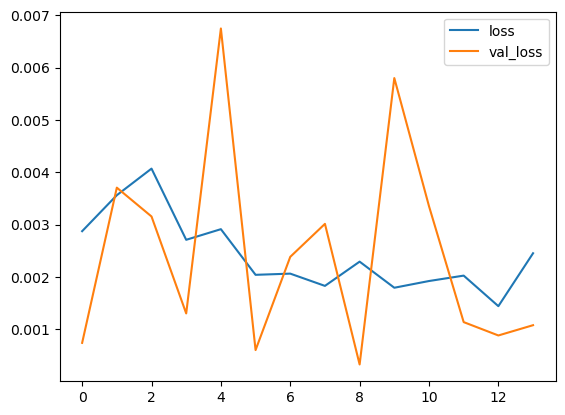

In [74]:
# Get Losses from dataframe (hint - model.history.history)- See previous week tutorial.
# Plot losses in the dataframe.
losses = model.history.history
plt.plot(losses['loss'])
plt.plot(losses['val_loss'])

plt.legend(['loss', 'val_loss'])
plt.show()

## Evaluate on Test Data

In [75]:
first_eval_batch = scaled_train[-length:]

In [76]:
n_input = 12
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
model.predict(first_eval_batch)


1/1 [==============================] - 0s 469ms/step


array([[0.61552024]], dtype=float32)

In [77]:
# compare with the true result:
scaled_test[0]

array([0.61856361])

#### Try predicting the series!

In [78]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for 
    # grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 44ms/step


## Inverse Transformations and Compare

In [79]:
true_predictions = scaler.inverse_transform(test_predictions)

In [80]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

C:\Users\Tulegenoff\AppData\Local\Temp\ipykernel_8444\1339453577.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


# Check and plot predictions

In [81]:
# Print the test variable.
print(test)

              Sales   Predictions
DATE                             
2022-07-01  24904.0  24795.010795
2022-08-01  26049.0  25270.326420
2022-09-01  23629.0  22097.744681
2022-10-01  24787.0  22791.741867
2022-11-01  28645.0  27610.655422
2022-12-01  39883.0  40497.332153
2023-01-01  19405.0  15334.006494
2023-02-01  20937.0  18848.406245
2023-03-01  24963.0  21422.826207
2023-04-01  24700.0  21606.564995
2023-05-01  26557.0  24258.038359
2023-06-01  24809.0  22143.398684
2023-07-01  25364.0  23239.472553
2023-08-01  27143.0  25671.218422
2023-09-01  23840.0  19981.262879
2023-10-01  24438.0  22061.233006
2023-11-01  29150.0  27458.012926
2023-12-01  41228.0  41661.590322


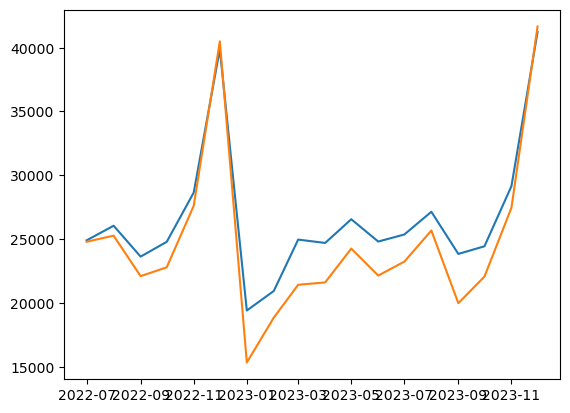

In [83]:
# Your code to plot actual sales and predictions.

plt.plot(test['Sales'])
plt.plot(test['Predictions'])